In [1]:
pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 3.9 MB/s eta 0:00:00


In [2]:
pip install gymnasium

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


def usable_ace(hand):
    """Verifica si un As puede usarse como 11 sin que la mano supere 21."""
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    """Calcula el total de la mano, considerando el valor del As."""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


class BlackjackEnv(gym.Env):
    """
    Entorno personalizado de Blackjack basado en Gymnasium.

    Simula un entorno de Blackjack con reglas específicas y soporte
    para conteo de cartas utilizando el método Hi-Lo.
    """
    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Inicialización de variables de estado y parámetros del entorno
        self.true_count = 0             # Conteo verdadero basado en cartas vistas
        self.running_count = 0          # Conteo acumulado de cartas según Hi-Lo
        self.deck = []                  # Mazo de cartas
        self.step_count = 0             # Contador de pasos por ronda
        self.max_steps = 100            # Máximo de pasos por ronda
        self.round_over = False         # Estado de la ronda actual
        self.first_move = True          # Indica si es el primer movimiento de la ronda
        self.cut_card_position = None   # Posición de la carta de corte en el mazo
        self.cut_card_reached = False   # Estado de la carta de corte alcanzada
        self.log = []                   # Registro de eventos del entorno

        # Configuración de apuestas
        self.bet_levels = [10, 20, 30]          # Opciones de apuesta
        self.current_bet = self.bet_levels[0]   # Apuesta actual
        self.min_bet = self.bet_levels[0]       # Apuesta mínima
        self.max_bet = self.bet_levels[-1]      # Apuesta máxima
        self.next_bet = self.bet_levels[0]      # Apuesta para la próxima ronda

        # Espacios de acción y observación
        self.action_space = spaces.Discrete(3)  # Acciones: plantarse, pedir, doblar
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -10, 0]),
            high=np.array([32, 11, 10, 1]),
            dtype=np.float32,
        )

        # Barajar el mazo inicial
        self.shuffle_deck()

    def shuffle_deck(self):
        """Barajar el mazo y reiniciar el conteo."""
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 8 * 4
        np.random.shuffle(self.deck)

        # Establecer la posición de la carta de corte entre el 50% y el 65% del mazo
        deck_size = len(self.deck)
        self.cut_card_position = np.random.randint(int(deck_size * 0.5), int(deck_size * 0.65))
        self.log.append(f"[DEBUG] Posición de la carta de corte establecida: {self.cut_card_position}")
        self.cut_card_reached = False

        # Reiniciar conteo y log
        self.running_count = 0
        self.true_count = 0
        self.log = []
        self.log.append("[SHUFFLE] Mazo barajado, conteo reiniciado.")

    def draw_card(self):
        """Robar una carta del mazo y verificar la carta de corte."""
        card = self.deck.pop()

        # Verificar si alcanzamos la carta de corte
        if len(self.deck) <= self.cut_card_position and not self.cut_card_reached:
            self.cut_card_reached = True
            self.log.append(f"[CUT CARD] Se alcanzó la carta de corte en posición {len(self.deck)}.")

        # Actualizar el conteo de cartas
        self.update_running_count([card])

        self.log.append(f"[DRAW CARD] Carta robada: {card}")
        return card


    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno para una nueva ronda.
        """
        if seed is not None:
            np.random.seed(seed)

        if self.cut_card_reached:
            self.log.append("[RESET] Barajando el mazo después de alcanzar la carta de corte.")
            self.shuffle_deck()
            self.cut_card_reached = False

        # Reinicia todos los parámetros de la ronda
        self.round_over = False
        self.step_count = 0
        self.first_move = True

        # Reparto inicial de cartas
        self.player_cards = [self.draw_card(), self.draw_card()]
        self.player_sum = sum_hand(self.player_cards)
        self.dealer_card = self.draw_card()
        self.dealer_cards = [self.dealer_card]

        self.player_blackjack = self._is_blackjack(self.player_cards)
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)
        self.current_bet = self.next_bet

        self.log.append(f"[RESET] Mano del jugador: {self.player_cards}, Carta del dealer: {self.dealer_card}")
        return self._get_obs(), {}

    def _is_blackjack(self, hand):
        """Determina si la mano tiene un Blackjack."""
        return len(hand) == 2 and sum_hand(hand) == 21

    def dealer_play(self):
        """Lógica para el turno del dealer."""
        # El dealer roba su carta 2 al inicio de su turno
        self.dealer_hidden_card = self.draw_card()
        self.dealer_cards.append(self.dealer_hidden_card)
        self.log.append(f"[DEALER] Carta 2 del dealer: {self.dealer_hidden_card}")
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)

        if not self._is_blackjack(self.dealer_cards) and not self._is_blackjack(self.player_cards):
            while sum_hand(self.dealer_cards) < 17:
                card = self.draw_card()
                self.dealer_cards.append(card)

        self.log.append(f"[DEALER] Cartas del dealer: {self.dealer_cards}")

    def step(self, action):
        """Realiza una acción del jugador."""
        reward = 0
        terminated = False
        truncated = False

        # Incrementar contador de pasos
        self.step_count += 1
        if self.step_count > self.max_steps:
            truncated = True
            reward = -self.current_bet
            return self._get_obs(), reward, terminated, truncated, {}

        # Evaluar si el jugador tiene Blackjack
        if self.player_blackjack:
            self.round_over = True
            self.log.append("[PLAYER] Blackjack detectado, paso al dealer.")
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Acciones del jugador
        if action == 0:  # Stand
            self.log.append("[ACTION] Stand")
            self.round_over = True
        elif action == 1:  # Hit
            self.log.append("[ACTION] Hit")
            card = self.draw_card()
            self.player_cards.append(card)
            self.player_sum = sum_hand(self.player_cards)
            self.first_move = False
            self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")

            # Si el jugador alcanza o supera 21, finaliza su turno
            if self.player_sum >= 21:
                self.log.append("[PLAYER] Mano alcanza o supera 21, turno finalizado.")
                self.round_over = True
        elif action == 2:  # Double
            self.log.append("[ACTION] Double")
            if self.first_move:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.current_bet = self.current_bet * 2
                self.first_move = False
                self.round_over = True
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}, Apuesta actual: {self.current_bet}")
            else:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.first_move = False
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")
                if self.player_sum >= 21:
                    self.round_over = True

        # Si el jugador se pasa, dealer gana automáticamente
        if self.player_sum > 21:
            self.log.append("[PLAYER] Mano se pasa de 21, dealer gana automáticamente.")
            reward = -self.current_bet
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Si la ronda ha terminado
        if self.round_over:
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True

        return self._get_obs(), reward, terminated, truncated, {}

    def adjust_bet(self):
        """Ajusta la apuesta para la próxima ronda según el true count."""
        if self.true_count < 1:
            self.next_bet = self.bet_levels[0]
        elif 1 <= self.true_count < 3:
            self.next_bet = self.bet_levels[1]
        else: # self.true_count > 3:
            self.next_bet = self.bet_levels[2]
        self.log.append(f"[ADJUST BET] Nueva apuesta establecida: {self.next_bet}")

    def update_running_count(self, cards):
        """Actualizar el conteo de cartas vistas."""
        hilo_values = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
        for card in cards:
            self.running_count += hilo_values.get(card, 0)

    def calculate_true_count(self):
        """Calcular el true count basado en el conteo actual y el mazo restante según el método Hi-Lo."""
        remaining_decks = len(self.deck) / 52
        if remaining_decks > 0:
            self.true_count = self.running_count / (remaining_decks * 2)
        else:
            self.true_count = 0
        self.log.append(f"[TRUE COUNT] Remaining decks: {remaining_decks}, Running count: {self.running_count}, True count: {self.true_count}")


    def _get_obs(self):
        """Devuelve la observación actual."""
        has_usable_ace = 1 if usable_ace(self.player_cards) else 0
        return np.array([self.player_sum, self.dealer_card, self.true_count, has_usable_ace], dtype=np.float32)

    def _calculate_reward(self):
        """Calcula el resultado de la ronda."""
        # Recompensas específicas para Blackjack
        if self.player_blackjack:
            if self.dealer_blackjack:
                return 0  # Empate
            else:
                return self.current_bet * 1.5  # Ganancia por Blackjack
        elif self.dealer_blackjack:
            return -self.current_bet  # Dealer gana con Blackjack

        # Recompensas estándar
        if self.player_sum > 21:
            return -self.current_bet
        elif sum_hand(self.dealer_cards) > 21 or self.player_sum > sum_hand(self.dealer_cards):
            return self.current_bet
        elif self.player_sum < sum_hand(self.dealer_cards):
            return -self.current_bet
        return 0


In [5]:
env = BlackjackEnv()
for _ in range(300):  # Robar muchas cartas
    card = env.draw_card()
    if env.cut_card_reached:
        print(f"Carta de corte alcanzada en posición {len(env.deck)}")
        break

Carta de corte alcanzada en posición 235


In [5]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [16]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import optuna

# Crear el entorno de evaluación
eval_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])  # Asegúrate de envolver con Monitor

# Configurar el callback de evaluación
eval_callback = EvalCallback(
    eval_env,                          # Entorno de evaluación
    best_model_save_path="./logs_a2c/",  # Carpeta para guardar el mejor modelo
    log_path="./logs_a2c/",              # Carpeta para guardar las evaluaciones
    eval_freq=5000,                      # Frecuencia de evaluación (en timesteps)
    n_eval_episodes=10,                  # Número de episodios por evaluación
    deterministic=True,                  # Política determinista
    render=False                         # No renderizar durante la evaluación
)

# Crear el entorno principal
train_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])  # También envolver con Monitor

# Función para buscar los mejores hiperparámetros con Optuna
def objective(trial):
    # Sugerir hiperparámetros
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_int('n_steps', 5, 1024, log=True)
    gamma = trial.suggest_float('gamma', 0.8, 0.999)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    ent_coef = trial.suggest_float('ent_coef', 1e-8, 0.1, log=True)

    # Configurar el modelo A2C con los hiperparámetros sugeridos
    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        vf_coef=vf_coef,
        ent_coef=ent_coef,
        verbose=0
    )

    # Entrenar el modelo
    model.learn(total_timesteps=50000, callback=eval_callback)

    # Evaluar el modelo en el entorno de evaluación
    mean_reward = 0
    for _ in range(10):  # Evaluar en 10 episodios
        obs = eval_env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = eval_env.step(action)  # Ajustar para 4 valores
            episode_reward += reward
        mean_reward += episode_reward
    mean_reward /= 10

    return mean_reward

# Crear el estudio de Optuna para optimizar los hiperparámetros
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Imprimir los mejores parámetros
best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2025-01-25 11:27:44,885] A new study created in memory with name: no-name-3265c9ff-4054-4e5b-8d86-2783e5cfe7d0


Eval num_timesteps=5000, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-3.00 +/- 11.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=8.50 +/- 7.43
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00


/usr/local/lib/python3.11/dist-packages/optuna/study/_tell.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(v)
[I 2025-01-25 11:29:18,368] Trial 0 finished with value: 3.0 and parameters: {'learning_rate': 0.00037893602994606057, 'n_steps': 6, 'gamma': 0.9382494163809819, 'vf_coef': 0.34584664577970947, 'ent_coef': 0.013088666822459466}. Best is trial 0 with value: 3.0.


Eval num_timesteps=50000, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4996, episode_reward=2.50 +/- 9.29
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9996, episode_reward=4.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14996, episode_reward=-8.00 +/- 6.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19996, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24996, episode_reward=4.50 +/- 9.34
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29996, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34996, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39996, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44996, episode_reward=-1.00 +/- 13.75
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:30:09,757] Trial 1 finished with value: -1.5 and parameters: {'learning_rate': 0.00035113874377112035, 'n_steps': 220, 'gamma': 0.9618613745900586, 'vf_coef': 0.3635671377827633, 'ent_coef': 0.029077398482116514}. Best is trial 0 with value: 3.0.


Eval num_timesteps=49996, episode_reward=3.00 +/- 20.02
Episode length: 1.00 +/- 0.00
Eval num_timesteps=4836, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9836, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14836, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19836, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24836, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29836, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34836, episode_reward=-7.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39836, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44836, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49836, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:31:28,747] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.0005869003603960342, 'n_steps': 9, 'gamma': 0.9972093269368291, 'vf_coef': 0.43853842841492685, 'ent_coef': 0.00013233731516587173}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4832, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9832, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14832, episode_reward=0.00 +/- 12.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19832, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24832, episode_reward=3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29832, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34832, episode_reward=0.00 +/- 10.95
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39832, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44832, episode_reward=-6.00 +/- 6.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49832, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:32:29,168] Trial 3 finished with value: -3.0 and parameters: {'learning_rate': 5.982847242312425e-05, 'n_steps': 23, 'gamma': 0.8749745061700298, 'vf_coef': 0.32129585360601, 'ent_coef': 0.0635170242507249}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4830, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9830, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14830, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19830, episode_reward=1.00 +/- 12.21
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24830, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29830, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34830, episode_reward=-7.00 +/- 17.92
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39830, episode_reward=-4.00 +/- 12.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44830, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49830, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:33:37,212] Trial 4 finished with value: -3.5 and parameters: {'learning_rate': 1.7786434922476555e-05, 'n_steps': 14, 'gamma': 0.8545808346540985, 'vf_coef': 0.11042445166770438, 'ent_coef': 0.008275629140164617}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4822, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9822, episode_reward=-7.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14822, episode_reward=-6.00 +/- 18.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19822, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24822, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29822, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34822, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39822, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44822, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49822, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:34:36,742] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 1.9427975342124264e-05, 'n_steps': 26, 'gamma': 0.9639337225603561, 'vf_coef': 0.3383996503722902, 'ent_coef': 1.911878970692639e-06}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4798, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9798, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14798, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19798, episode_reward=3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24798, episode_reward=2.00 +/- 9.54
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29798, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34798, episode_reward=5.50 +/- 8.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39798, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44798, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49798, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:35:28,144] Trial 6 finished with value: -1.0 and parameters: {'learning_rate': 0.0005441725691665098, 'n_steps': 113, 'gamma': 0.9627957358562728, 'vf_coef': 0.8490891100993573, 'ent_coef': 0.05963691992425386}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4739, episode_reward=9.00 +/- 13.00
Episode length: 1.00 +/- 0.00
New best mean reward!
Eval num_timesteps=9739, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14739, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19739, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24739, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29739, episode_reward=-8.00 +/- 12.49
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34739, episode_reward=-0.50 +/- 14.22
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39739, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44739, episode_reward=3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49739, episode_reward=-2.00 +/- 16.61
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:36:21,834] Trial 7 finished with value: -2.0 and parameters: {'learning_rate': 0.0009268244372359132, 'n_steps': 61, 'gamma': 0.9923469656545922, 'vf_coef': 0.9749865657010407, 'ent_coef': 6.818087998789252e-05}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4719, episode_reward=2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9719, episode_reward=6.50 +/- 8.38
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14719, episode_reward=1.50 +/- 11.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19719, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24719, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29719, episode_reward=1.00 +/- 10.44
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34719, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39719, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44719, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49719, episode_reward=9.50 +/- 10.59
Episode length: 1.00 +/- 0.00
New best mean reward!


[I 2025-01-25 11:37:11,644] Trial 8 finished with value: -1.5 and parameters: {'learning_rate': 0.0004933316508667893, 'n_steps': 438, 'gamma': 0.8590046258140763, 'vf_coef': 0.859750600974237, 'ent_coef': 3.3941191606385136e-07}. Best is trial 0 with value: 3.0.


Eval num_timesteps=4349, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9349, episode_reward=0.00 +/- 13.42
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14349, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19349, episode_reward=5.00 +/- 10.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24349, episode_reward=4.00 +/- 12.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29349, episode_reward=2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34349, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39349, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44349, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49349, episode_reward=-8.00 +/- 6.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:38:05,616] Trial 9 finished with value: 6.0 and parameters: {'learning_rate': 8.199489172931019e-05, 'n_steps': 56, 'gamma': 0.8142805165023685, 'vf_coef': 0.5788690370969878, 'ent_coef': 0.023647959586904327}. Best is trial 9 with value: 6.0.


Eval num_timesteps=4341, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=9341, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=14341, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=19341, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=24341, episode_reward=-4.00 +/- 18.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=29341, episode_reward=-11.00 +/- 13.75
Episode length: 1.00 +/- 0.00
Eval num_timesteps=34341, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=39341, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=44341, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=49341, episode_reward=2.50 +/- 11.01
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:38:54,538] Trial 10 finished with value: -4.0 and parameters: {'learning_rate': 0.0001109007465803518, 'n_steps': 859, 'gamma': 0.8002773735875585, 'vf_coef': 0.6643064472047039, 'ent_coef': 0.0006418158836794003}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3660, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8660, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13660, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18660, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23660, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28660, episode_reward=1.50 +/- 11.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33660, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38660, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43660, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48660, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:40:31,407] Trial 11 finished with value: -4.0 and parameters: {'learning_rate': 0.00016774440834692067, 'n_steps': 5, 'gamma': 0.921398570117586, 'vf_coef': 0.6001154987267343, 'ent_coef': 1.1347429588077614e-08}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3660, episode_reward=-1.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8660, episode_reward=0.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13660, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18660, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23660, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28660, episode_reward=0.00 +/- 10.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33660, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38660, episode_reward=-4.50 +/- 7.89
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43660, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48660, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:41:24,811] Trial 12 finished with value: 3.0 and parameters: {'learning_rate': 4.688682883036915e-05, 'n_steps': 56, 'gamma': 0.8014992073068389, 'vf_coef': 0.16329053950588912, 'ent_coef': 0.0020592674055374106}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3652, episode_reward=-5.00 +/- 6.71
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8652, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13652, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18652, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23652, episode_reward=-5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28652, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33652, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38652, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43652, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48652, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:43:03,385] Trial 13 finished with value: 0.0 and parameters: {'learning_rate': 0.00021247218070383857, 'n_steps': 5, 'gamma': 0.9150807496006881, 'vf_coef': 0.6986934294730659, 'ent_coef': 0.0024163405585029196}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3652, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8652, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13652, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18652, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23652, episode_reward=4.00 +/- 10.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28652, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33652, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38652, episode_reward=-8.00 +/- 6.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43652, episode_reward=2.00 +/- 7.48
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48652, episode_reward=2.00 +/- 8.72
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:43:53,082] Trial 14 finished with value: 1.0 and parameters: {'learning_rate': 4.371081388238576e-05, 'n_steps': 153, 'gamma': 0.8286574187616083, 'vf_coef': 0.4959916117324646, 'ent_coef': 5.027481304755643e-06}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3621, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8621, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13621, episode_reward=6.00 +/- 8.89
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18621, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23621, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28621, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33621, episode_reward=-5.00 +/- 15.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38621, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43621, episode_reward=-6.50 +/- 7.76
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48621, episode_reward=-4.50 +/- 9.07
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:44:52,661] Trial 15 finished with value: -9.0 and parameters: {'learning_rate': 8.56421670528104e-05, 'n_steps': 27, 'gamma': 0.8946826460585249, 'vf_coef': 0.2307580654642166, 'ent_coef': 0.00036265391336742856}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3617, episode_reward=-7.00 +/- 14.87
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8617, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13617, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18617, episode_reward=0.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23617, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28617, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33617, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38617, episode_reward=-2.00 +/- 17.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43617, episode_reward=5.00 +/- 10.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48617, episode_reward=-0.50 +/- 10.11
Episode length: 1.20 +/- 0.60


[I 2025-01-25 11:46:03,883] Trial 16 finished with value: 0.0 and parameters: {'learning_rate': 0.00022887951316014405, 'n_steps': 11, 'gamma': 0.9281267913187793, 'vf_coef': 0.5392196273715033, 'ent_coef': 0.0044600031343063895}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3611, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8611, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13611, episode_reward=-3.00 +/- 15.52
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18611, episode_reward=-8.00 +/- 14.70
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23611, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28611, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33611, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38611, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43611, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48611, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:46:53,270] Trial 17 finished with value: -3.5 and parameters: {'learning_rate': 0.00011703012086852946, 'n_steps': 335, 'gamma': 0.943107883519747, 'vf_coef': 0.7464192300809598, 'ent_coef': 0.012804775853279144}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3361, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8361, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13361, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18361, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23361, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28361, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33361, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38361, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43361, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48361, episode_reward=4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:47:47,651] Trial 18 finished with value: -2.5 and parameters: {'learning_rate': 3.011886103875036e-05, 'n_steps': 42, 'gamma': 0.8256206511662766, 'vf_coef': 0.40694156917535174, 'ent_coef': 9.838886453052055e-06}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3339, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8339, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13339, episode_reward=-9.00 +/- 3.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18339, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23339, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28339, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33339, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38339, episode_reward=0.50 +/- 11.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43339, episode_reward=-7.00 +/- 17.92
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48339, episode_reward=-10.00 +/- 15.49
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:48:37,865] Trial 19 finished with value: -7.0 and parameters: {'learning_rate': 1.0911029654478516e-05, 'n_steps': 101, 'gamma': 0.8925343073006927, 'vf_coef': 0.2420681387246897, 'ent_coef': 0.0007718272374657547}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3243, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8243, episode_reward=-5.00 +/- 8.06
Episode length: 1.10 +/- 0.30
Eval num_timesteps=13243, episode_reward=4.50 +/- 9.60
Episode length: 1.30 +/- 0.64
Eval num_timesteps=18243, episode_reward=1.50 +/- 10.01
Episode length: 1.30 +/- 0.46
Eval num_timesteps=23243, episode_reward=-1.00 +/- 9.43
Episode length: 1.10 +/- 0.30
Eval num_timesteps=28243, episode_reward=0.50 +/- 10.59
Episode length: 1.10 +/- 0.30
Eval num_timesteps=33243, episode_reward=0.50 +/- 9.60
Episode length: 1.40 +/- 0.66
Eval num_timesteps=38243, episode_reward=-2.00 +/- 9.80
Episode length: 1.30 +/- 0.64
Eval num_timesteps=43243, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48243, episode_reward=-4.00 +/- 9.17
Episode length: 1.10 +/- 0.30


[I 2025-01-25 11:50:02,233] Trial 20 finished with value: -3.0 and parameters: {'learning_rate': 0.0003015170883827995, 'n_steps': 7, 'gamma': 0.8736261322275811, 'vf_coef': 0.591690041275412, 'ent_coef': 0.09514477590879535}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3242, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8242, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13242, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18242, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23242, episode_reward=-3.50 +/- 8.96
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28242, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33242, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38242, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43242, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48242, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:50:55,242] Trial 21 finished with value: 5.5 and parameters: {'learning_rate': 5.0612175024856515e-05, 'n_steps': 53, 'gamma': 0.8002869384255674, 'vf_coef': 0.10452513347731729, 'ent_coef': 0.0024809584244934032}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3210, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8210, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13210, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18210, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23210, episode_reward=2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28210, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33210, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38210, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43210, episode_reward=-4.50 +/- 11.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48210, episode_reward=7.50 +/- 15.04
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:51:50,030] Trial 22 finished with value: -3.5 and parameters: {'learning_rate': 7.205337677490314e-05, 'n_steps': 38, 'gamma': 0.8243988206293015, 'vf_coef': 0.2693257440686961, 'ent_coef': 0.00915312804961061}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3202, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8202, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13202, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18202, episode_reward=4.50 +/- 14.57
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23202, episode_reward=-8.00 +/- 14.70
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28202, episode_reward=1.00 +/- 19.21
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33202, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38202, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43202, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48202, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:52:52,026] Trial 23 finished with value: -1.5 and parameters: {'learning_rate': 0.00014930458083469054, 'n_steps': 18, 'gamma': 0.8408995494049772, 'vf_coef': 0.15905559324010426, 'ent_coef': 0.0014738615230547687}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3198, episode_reward=-6.00 +/- 6.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8198, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13198, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18198, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23198, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28198, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33198, episode_reward=-8.00 +/- 6.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38198, episode_reward=-4.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43198, episode_reward=-3.50 +/- 8.96
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48198, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:53:43,664] Trial 24 finished with value: -7.0 and parameters: {'learning_rate': 2.7580458414269913e-05, 'n_steps': 89, 'gamma': 0.8079774957382692, 'vf_coef': 0.4906488076470288, 'ent_coef': 0.018684905496882988}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3180, episode_reward=-1.00 +/- 11.36
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8180, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13180, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18180, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23180, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28180, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33180, episode_reward=-3.00 +/- 13.45
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38180, episode_reward=4.00 +/- 10.20
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43180, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48180, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:54:33,771] Trial 25 finished with value: 2.5 and parameters: {'learning_rate': 4.837419657911859e-05, 'n_steps': 185, 'gamma': 0.8152585629621913, 'vf_coef': 0.4086202387429291, 'ent_coef': 0.00017363203980802415}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3045, episode_reward=1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8045, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13045, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18045, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23045, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28045, episode_reward=-1.00 +/- 12.21
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33045, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38045, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43045, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48045, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:55:28,980] Trial 26 finished with value: -4.0 and parameters: {'learning_rate': 3.358541958473809e-05, 'n_steps': 35, 'gamma': 0.9415338625565867, 'vf_coef': 0.18096780776182272, 'ent_coef': 3.156872473858091e-05}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3030, episode_reward=-6.00 +/- 6.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8030, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13030, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18030, episode_reward=0.00 +/- 14.83
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23030, episode_reward=-3.00 +/- 19.52
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28030, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33030, episode_reward=-1.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38030, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43030, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48030, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:56:35,166] Trial 27 finished with value: 0.0 and parameters: {'learning_rate': 7.693775305687364e-05, 'n_steps': 15, 'gamma': 0.8476286540058019, 'vf_coef': 0.28804581152717434, 'ent_coef': 0.004286328802971765}. Best is trial 9 with value: 6.0.


Eval num_timesteps=3020, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=8020, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=13020, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=18020, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=23020, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=28020, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=33020, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=38020, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=43020, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=48020, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:57:27,381] Trial 28 finished with value: -4.0 and parameters: {'learning_rate': 0.00013708534650675396, 'n_steps': 69, 'gamma': 0.8720787265324521, 'vf_coef': 0.47272018388316556, 'ent_coef': 0.041345514929992284}. Best is trial 9 with value: 6.0.


Eval num_timesteps=2995, episode_reward=-8.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=7995, episode_reward=0.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=12995, episode_reward=0.00 +/- 10.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=17995, episode_reward=-1.50 +/- 10.50
Episode length: 1.30 +/- 0.46
Eval num_timesteps=22995, episode_reward=-1.00 +/- 9.43
Episode length: 1.50 +/- 0.67
Eval num_timesteps=27995, episode_reward=-2.00 +/- 9.80
Episode length: 1.30 +/- 0.46
Eval num_timesteps=32995, episode_reward=0.00 +/- 10.00
Episode length: 1.20 +/- 0.60
Eval num_timesteps=37995, episode_reward=0.50 +/- 9.60
Episode length: 1.50 +/- 0.67
Eval num_timesteps=42995, episode_reward=-4.00 +/- 9.17
Episode length: 1.40 +/- 0.66
Eval num_timesteps=47995, episode_reward=0.50 +/- 10.59
Episode length: 1.30 +/- 0.46


[I 2025-01-25 11:58:16,813] Trial 29 finished with value: -1.0 and parameters: {'learning_rate': 0.0009114686359078781, 'n_steps': 312, 'gamma': 0.9760095689375822, 'vf_coef': 0.10320367281057119, 'ent_coef': 0.02095042124217149}. Best is trial 9 with value: 6.0.


Eval num_timesteps=2763, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=7763, episode_reward=2.50 +/- 11.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=12763, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=17763, episode_reward=-5.00 +/- 6.71
Episode length: 1.00 +/- 0.00
Eval num_timesteps=22763, episode_reward=-9.00 +/- 7.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=27763, episode_reward=-1.50 +/- 13.05
Episode length: 1.00 +/- 0.00
Eval num_timesteps=32763, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=37763, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=42763, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=47763, episode_reward=1.00 +/- 11.36
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:59:05,297] Trial 30 finished with value: 4.5 and parameters: {'learning_rate': 0.0003236164662812513, 'n_steps': 639, 'gamma': 0.9037861011487314, 'vf_coef': 0.37398546298363355, 'ent_coef': 0.00037994964945464195}. Best is trial 9 with value: 6.0.


Eval num_timesteps=2282, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=7282, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=12282, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=17282, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=22282, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=27282, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=32282, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=37282, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=42282, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=47282, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00


[I 2025-01-25 11:59:54,281] Trial 31 finished with value: 2.5 and parameters: {'learning_rate': 0.00034507992615058844, 'n_steps': 822, 'gamma': 0.9009291001936298, 'vf_coef': 0.37533653120788635, 'ent_coef': 0.0003979885109761264}. Best is trial 9 with value: 6.0.


Eval num_timesteps=2140, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00
Eval num_timesteps=7140, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=12140, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=17140, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=22140, episode_reward=-4.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=27140, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=32140, episode_reward=-4.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=37140, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=42140, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=47140, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:00:44,729] Trial 32 finished with value: -1.5 and parameters: {'learning_rate': 0.00027881313435160215, 'n_steps': 145, 'gamma': 0.9377799234976779, 'vf_coef': 0.5654942396052547, 'ent_coef': 0.004839599391977704}. Best is trial 9 with value: 6.0.


Eval num_timesteps=2115, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=7115, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=12115, episode_reward=-8.00 +/- 12.49
Episode length: 1.00 +/- 0.00
Eval num_timesteps=17115, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=22115, episode_reward=3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=27115, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=32115, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=37115, episode_reward=-5.50 +/- 14.22
Episode length: 1.00 +/- 0.00
Eval num_timesteps=42115, episode_reward=-8.00 +/- 4.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=47115, episode_reward=-4.00 +/- 14.97
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:01:33,117] Trial 33 finished with value: -0.5 and parameters: {'learning_rate': 0.00041312326621547636, 'n_steps': 508, 'gamma': 0.9061626908051352, 'vf_coef': 0.6440014305647921, 'ent_coef': 0.00013153990436141316}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1823, episode_reward=3.50 +/- 11.19
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6823, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11823, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16823, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21823, episode_reward=-6.00 +/- 16.25
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26823, episode_reward=1.00 +/- 12.21
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31823, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36823, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41823, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46823, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:02:22,720] Trial 34 finished with value: -7.0 and parameters: {'learning_rate': 0.0007373312981691853, 'n_steps': 221, 'gamma': 0.8358459267748887, 'vf_coef': 0.31121703418443686, 'ent_coef': 0.0013988976676216932}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1656, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6656, episode_reward=-6.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11656, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16656, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21656, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26656, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31656, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36656, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41656, episode_reward=7.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46656, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:03:39,128] Trial 35 finished with value: -2.0 and parameters: {'learning_rate': 5.96404876509663e-05, 'n_steps': 9, 'gamma': 0.8837378977790646, 'vf_coef': 0.43164401223785187, 'ent_coef': 0.027046711516541568}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1652, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6652, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11652, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16652, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21652, episode_reward=0.00 +/- 12.65
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26652, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31652, episode_reward=1.00 +/- 9.43
Episode length: 1.10 +/- 0.30
Eval num_timesteps=36652, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41652, episode_reward=2.00 +/- 9.80
Episode length: 1.40 +/- 0.66
Eval num_timesteps=46652, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:04:38,599] Trial 36 finished with value: 3.0 and parameters: {'learning_rate': 0.00019084915691933247, 'n_steps': 22, 'gamma': 0.9497067336172617, 'vf_coef': 0.3549481490666941, 'ent_coef': 0.008987099307072675}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1646, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6646, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11646, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16646, episode_reward=-4.00 +/- 9.17
Episode length: 1.10 +/- 0.30
Eval num_timesteps=21646, episode_reward=-2.50 +/- 9.81
Episode length: 1.30 +/- 0.46
Eval num_timesteps=26646, episode_reward=0.00 +/- 10.00
Episode length: 1.60 +/- 1.20
Eval num_timesteps=31646, episode_reward=-4.00 +/- 9.17
Episode length: 1.20 +/- 0.40
Eval num_timesteps=36646, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41646, episode_reward=-7.50 +/- 7.50
Episode length: 1.30 +/- 0.64
Eval num_timesteps=46646, episode_reward=0.00 +/- 7.75
Episode length: 1.30 +/- 0.46


[I 2025-01-25 12:05:31,797] Trial 37 finished with value: -2.0 and parameters: {'learning_rate': 0.00039573471235002496, 'n_steps': 50, 'gamma': 0.8134555134687746, 'vf_coef': 0.5236555981739005, 'ent_coef': 5.290823786864082e-05}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1646, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6646, episode_reward=-7.50 +/- 10.78
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11646, episode_reward=6.00 +/- 8.89
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16646, episode_reward=-3.00 +/- 13.45
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21646, episode_reward=-14.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26646, episode_reward=-2.00 +/- 14.70
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31646, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36646, episode_reward=-7.00 +/- 11.87
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41646, episode_reward=-6.00 +/- 13.56
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46646, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:06:23,822] Trial 38 finished with value: 0.0 and parameters: {'learning_rate': 0.0006191869573461351, 'n_steps': 71, 'gamma': 0.8625710425295565, 'vf_coef': 0.7488812374224711, 'ent_coef': 0.052505182103553115}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1591, episode_reward=-10.00 +/- 13.42
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6591, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11591, episode_reward=-3.00 +/- 11.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16591, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21591, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26591, episode_reward=0.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31591, episode_reward=4.50 +/- 9.60
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36591, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41591, episode_reward=0.00 +/- 10.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46591, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:07:19,624] Trial 39 finished with value: 3.5 and parameters: {'learning_rate': 2.0292285018568908e-05, 'n_steps': 31, 'gamma': 0.9109707320871249, 'vf_coef': 0.219391639129345, 'ent_coef': 0.0002737317498115929}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1588, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6588, episode_reward=-1.00 +/- 14.46
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11588, episode_reward=-1.00 +/- 11.36
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16588, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21588, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26588, episode_reward=4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31588, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36588, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41588, episode_reward=5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46588, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:08:15,760] Trial 40 finished with value: -1.5 and parameters: {'learning_rate': 1.4688741527752712e-05, 'n_steps': 30, 'gamma': 0.909740534741447, 'vf_coef': 0.18342743023977093, 'ent_coef': 1.4571317562426969e-05}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1578, episode_reward=-1.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6578, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11578, episode_reward=-7.00 +/- 6.40
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16578, episode_reward=0.00 +/- 8.94
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21578, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26578, episode_reward=0.00 +/- 13.42
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31578, episode_reward=-8.00 +/- 18.33
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36578, episode_reward=0.00 +/- 20.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41578, episode_reward=-6.00 +/- 14.28
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46578, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:09:07,120] Trial 41 finished with value: -4.0 and parameters: {'learning_rate': 2.1327328312261025e-05, 'n_steps': 85, 'gamma': 0.9300013088568766, 'vf_coef': 0.2179784474546679, 'ent_coef': 0.00027517884504042067}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1513, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6513, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11513, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16513, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21513, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26513, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31513, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36513, episode_reward=-1.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41513, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46513, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:10:00,227] Trial 42 finished with value: -3.5 and parameters: {'learning_rate': 0.00010362278429672748, 'n_steps': 51, 'gamma': 0.9190723050530266, 'vf_coef': 0.13186936797197463, 'ent_coef': 0.0009134953508215394}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1482, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6482, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11482, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16482, episode_reward=0.50 +/- 10.59
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21482, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26482, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31482, episode_reward=-1.50 +/- 10.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36482, episode_reward=4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41482, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46482, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:10:59,712] Trial 43 finished with value: 1.0 and parameters: {'learning_rate': 2.3161853133393616e-05, 'n_steps': 21, 'gamma': 0.9505366937442573, 'vf_coef': 0.303852564995423, 'ent_coef': 8.688665733281122e-05}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1481, episode_reward=-10.00 +/- 0.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6481, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11481, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16481, episode_reward=2.50 +/- 10.31
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21481, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26481, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31481, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36481, episode_reward=5.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41481, episode_reward=-0.50 +/- 10.11
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46481, episode_reward=2.50 +/- 9.29
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:12:08,699] Trial 44 finished with value: 2.0 and parameters: {'learning_rate': 1.6257576676628054e-05, 'n_steps': 12, 'gamma': 0.8847476306915252, 'vf_coef': 0.36042237950260353, 'ent_coef': 0.0033205776037559614}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1477, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6477, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11477, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16477, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21477, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26477, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31477, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36477, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41477, episode_reward=2.00 +/- 10.54
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46477, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:12:58,679] Trial 45 finished with value: -8.0 and parameters: {'learning_rate': 6.174176265771414e-05, 'n_steps': 136, 'gamma': 0.9830265373056315, 'vf_coef': 0.2281692819737945, 'ent_coef': 0.0004822510999000305}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1429, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6429, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11429, episode_reward=2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16429, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21429, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26429, episode_reward=-4.50 +/- 9.07
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31429, episode_reward=-8.00 +/- 6.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36429, episode_reward=2.50 +/- 12.89
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41429, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46429, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:14:22,146] Trial 46 finished with value: -1.5 and parameters: {'learning_rate': 3.7262664997499886e-05, 'n_steps': 7, 'gamma': 0.9242235726250565, 'vf_coef': 0.13478450133626793, 'ent_coef': 1.3166386364154728e-06}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1428, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6428, episode_reward=-6.00 +/- 11.14
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11428, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16428, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21428, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26428, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31428, episode_reward=1.00 +/- 11.36
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36428, episode_reward=4.00 +/- 12.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41428, episode_reward=-6.00 +/- 6.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46428, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:15:15,589] Trial 47 finished with value: -2.0 and parameters: {'learning_rate': 1.242176616654704e-05, 'n_steps': 44, 'gamma': 0.9129360837372068, 'vf_coef': 0.2632652699618413, 'ent_coef': 1.6298906547422646e-08}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1400, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11400, episode_reward=-5.00 +/- 8.06
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16400, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21400, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26400, episode_reward=-2.00 +/- 8.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31400, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36400, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41400, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46400, episode_reward=-5.50 +/- 9.07
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:16:12,796] Trial 48 finished with value: 2.0 and parameters: {'learning_rate': 0.00026139309640268814, 'n_steps': 30, 'gamma': 0.9550508888186015, 'vf_coef': 0.19237629438671316, 'ent_coef': 0.001809751198182317}. Best is trial 9 with value: 6.0.


Eval num_timesteps=1390, episode_reward=-3.00 +/- 9.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=6390, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=11390, episode_reward=-2.00 +/- 9.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=16390, episode_reward=1.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=21390, episode_reward=-3.00 +/- 10.77
Episode length: 1.00 +/- 0.00
Eval num_timesteps=26390, episode_reward=3.50 +/- 9.50
Episode length: 1.00 +/- 0.00
Eval num_timesteps=31390, episode_reward=4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
Eval num_timesteps=36390, episode_reward=-2.50 +/- 9.81
Episode length: 1.00 +/- 0.00
Eval num_timesteps=41390, episode_reward=-1.00 +/- 14.46
Episode length: 1.00 +/- 0.00
Eval num_timesteps=46390, episode_reward=-3.00 +/- 11.00
Episode length: 1.00 +/- 0.00


[I 2025-01-25 12:17:03,965] Trial 49 finished with value: -6.5 and parameters: {'learning_rate': 0.0001346627173848908, 'n_steps': 65, 'gamma': 0.9689808245776826, 'vf_coef': 0.45289065248730354, 'ent_coef': 0.005887416283110812}. Best is trial 9 with value: 6.0.


Best hyperparameters: {'learning_rate': 8.199489172931019e-05, 'n_steps': 56, 'gamma': 0.8142805165023685, 'vf_coef': 0.5788690370969878, 'ent_coef': 0.023647959586904327}


In [17]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

# Crear el entorno de entrenamiento
train_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Crear el entorno de evaluación
eval_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Configurar el callback de evaluación
eval_callback = EvalCallback(
    eval_env,                          # Entorno de evaluación
    best_model_save_path="./logs_a2c/",  # Carpeta para guardar el mejor modelo
    log_path="./logs_a2c/",              # Carpeta para guardar las evaluaciones
    eval_freq=10000,                     # Frecuencia de evaluación (en timesteps)
    n_eval_episodes=10,                  # Número de episodios por evaluación
    deterministic=True,                  # Política determinista
    render=False                         # No renderizar durante la evaluación
)

# Usar los mejores hiperparámetros obtenidos con Optuna
best_params = {
    'learning_rate': 8.199489172931019e-05,
    'n_steps': 56,
    'gamma': 0.8142805165023685,
    'vf_coef': 0.5788690370969878,
    'ent_coef': 0.023647959586904327
}

# Crear y configurar el modelo A2C
model = A2C(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=best_params['learning_rate'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    vf_coef=best_params['vf_coef'],
    ent_coef=best_params['ent_coef'],
    verbose=1
)

# Entrenar el modelo
model.learn(total_timesteps=500000, callback=eval_callback)

# Guardar el modelo entrenado
model.save("a2c_blackjack")

print("Entrenamiento completado y modelo guardado como 'a2c_blackjack'.")


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.14     |
|    ep_rew_mean        | -3       |
| time/                 |          |
|    fps                | 1001     |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 5600     |
| train/                |          |
|    entropy_loss       | -0.891   |
|    explained_variance | 0.00483  |
|    learning_rate      | 8.2e-05  |
|    n_updates          | 99       |
|    policy_loss        | 0.348    |
|    value_loss         | 121      |
------------------------------------
Eval num_timesteps=10000, episode_reward=-4.00 +/- 9.17
Episode length: 1.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 1        |
|    mean_reward        | -4       |
| time/                 |          |
|    total_timesteps    | 10000    |
| train/                |          |
|    entr

In [18]:
# Descargar el modelo
from google.colab import files
files.download('a2c_blackjack.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import shutil
from google.colab import files

# Comprimir la carpeta de logs
shutil.make_archive("logs_a2c", "zip", "./logs_a2c")

# Descargar el archivo comprimido
files.download("logs_a2c.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

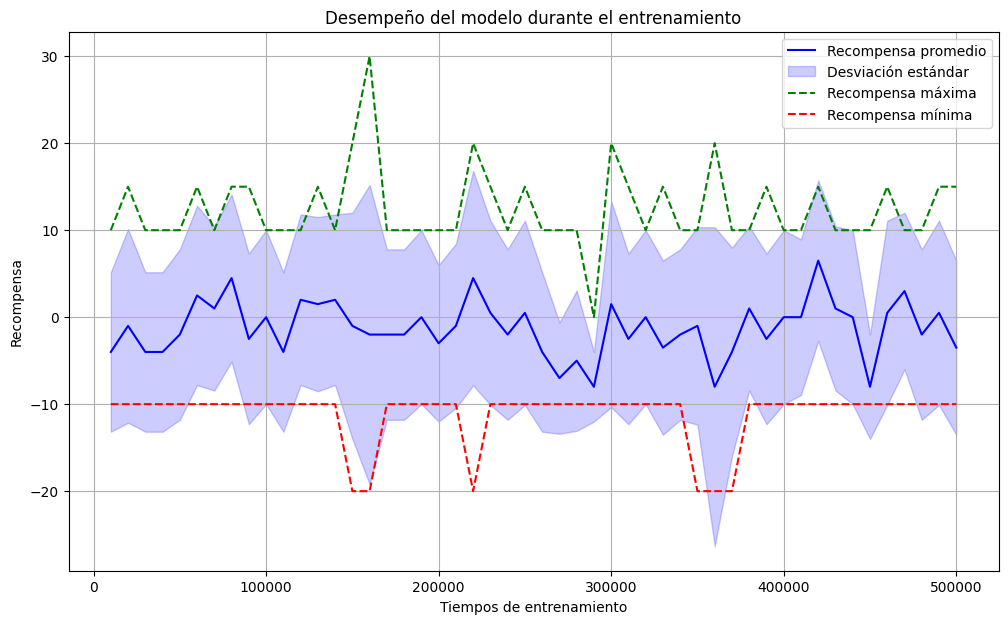

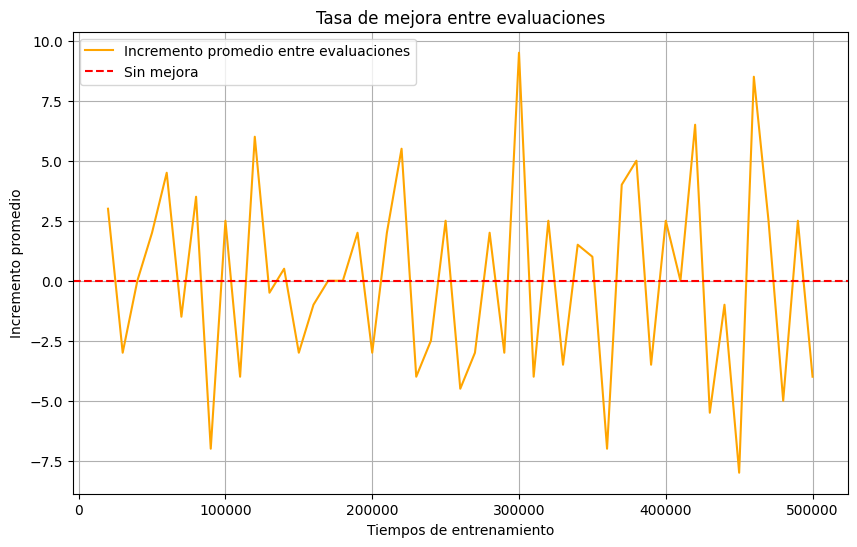

Estabilidad de las últimas recompensas (desviación estándar): 3.64
Porcentaje de evaluaciones con recompensa promedio > 0.8: 24.00%
El mejor modelo se obtuvo en el timestep 420000 con una recompensa promedio de 6.50


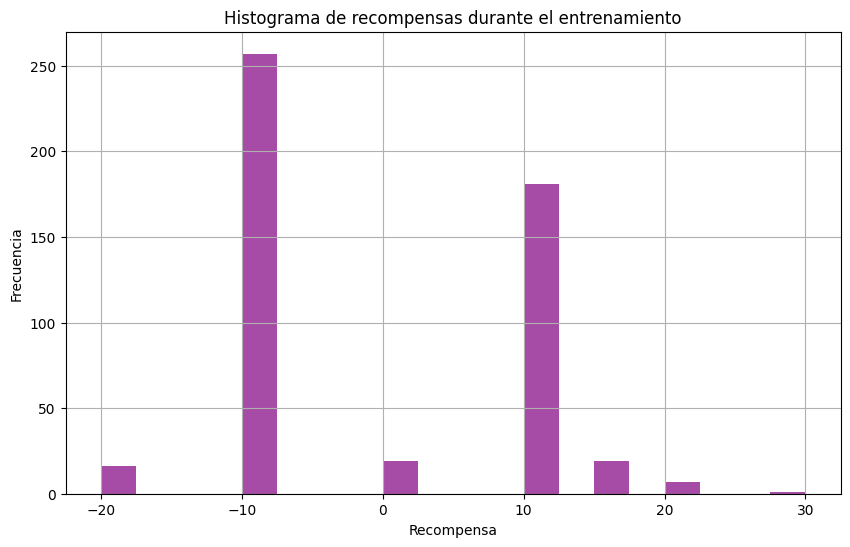

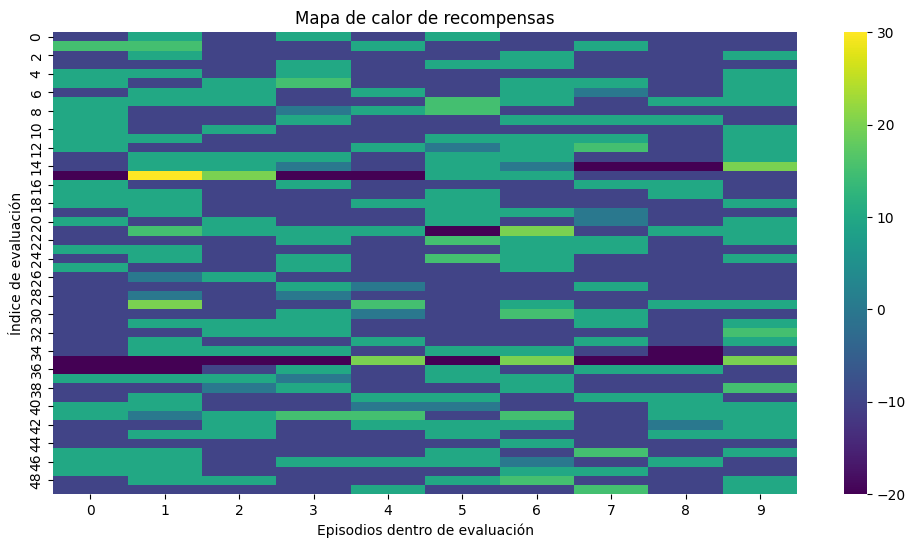

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos del archivo de evaluaciones
log_path = "./logs_a2c/evaluations.npz"
data = np.load(log_path)

# Extraer información relevante
timesteps = data["timesteps"]
mean_rewards = data["results"].mean(axis=1)
std_rewards = data["results"].std(axis=1)
max_rewards = data["results"].max(axis=1)
min_rewards = data["results"].min(axis=1)

# Graficar el desempeño del modelo con promedio, desviación estándar, máximo y mínimo
plt.figure(figsize=(12, 7))
plt.plot(timesteps, mean_rewards, label="Recompensa promedio", color="b")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.2,
    label="Desviación estándar",
    color="b"
)
plt.plot(timesteps, max_rewards, label="Recompensa máxima", linestyle="--", color="g")
plt.plot(timesteps, min_rewards, label="Recompensa mínima", linestyle="--", color="r")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Recompensa")
plt.title("Desempeño del modelo durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

# Tasa de mejora promedio entre evaluaciones
mean_diff = np.diff(mean_rewards)
plt.figure(figsize=(10, 6))
plt.plot(timesteps[1:], mean_diff, label="Incremento promedio entre evaluaciones", color="orange")
plt.axhline(0, color="red", linestyle="--", label="Sin mejora")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Incremento promedio")
plt.title("Tasa de mejora entre evaluaciones")
plt.legend()
plt.grid()
plt.show()

# Estabilidad en las últimas evaluaciones
last_rewards = data["results"][-10:]
last_variance = np.std(mean_rewards[-10:])
print(f"Estabilidad de las últimas recompensas (desviación estándar): {last_variance:.2f}")

# Porcentaje de evaluaciones que superan un umbral de recompensa
threshold = 0.8
above_threshold = np.sum(mean_rewards > threshold) / len(mean_rewards) * 100
print(f"Porcentaje de evaluaciones con recompensa promedio > {threshold}: {above_threshold:.2f}%")

# Identificar el mejor modelo y cuándo se obtuvo
best_eval_idx = np.argmax(mean_rewards)
best_timestep = timesteps[best_eval_idx]
best_mean_reward = mean_rewards[best_eval_idx]
print(f"El mejor modelo se obtuvo en el timestep {best_timestep} con una recompensa promedio de {best_mean_reward:.2f}")

# Histograma de recompensas
all_rewards = data["results"].flatten()
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=20, alpha=0.7, color="purple")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.title("Histograma de recompensas durante el entrenamiento")
plt.grid()
plt.show()

# Mapa de calor de recompensas
plt.figure(figsize=(12, 6))
sns.heatmap(data["results"], cmap="viridis", cbar=True)
plt.xlabel("Episodios dentro de evaluación")
plt.ylabel("Índice de evaluación")
plt.title("Mapa de calor de recompensas")
plt.show()

In [6]:
# Subir archivo a Colab
from google.colab import files

# Subir el archivo
uploaded = files.upload()

# Verificar los archivos subidos
for filename in uploaded.keys():
    print(f"Archivo subido: {filename}")

Saving a2c_blackjack.zip to a2c_blackjack.zip
Archivo subido: a2c_blackjack.zip


Se han truncado las últimas 5000 líneas del flujo de salida.
Recompensa total en el episodio 99664: -10
[DRAW CARD] Carta robada: 7
[DRAW CARD] Carta robada: 7
[DRAW CARD] Carta robada: 9
[RESET] Mano del jugador: [7, 7], Carta del dealer: 9
[ACTION] Hit
[DRAW CARD] Carta robada: 10
[PLAYER] Carta añadida: 10, Mano actual: [7, 7, 10]
[PLAYER] Mano alcanza o supera 21, turno finalizado.
[PLAYER] Mano se pasa de 21, dealer gana automáticamente.
[TRUE COUNT] Remaining decks: 6.923076923076923, Running count: -5, True count: -0.3611111111111111
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99665 ---
Recompensa total en el episodio 99665: 0
[DRAW CARD] Carta robada: 1
[DRAW CARD] Carta robada: 10
[DRAW CARD] Carta robada: 10
[RESET] Mano del jugador: [1, 10], Carta del dealer: 10
[PLAYER] Blackjack detectado, paso al dealer.
[DRAW CARD] Carta robada: 1
[DEALER] Carta 2 del dealer: 1
[DEALER] Cartas del dealer: [10, 1]
[TRUE COUNT] Remaining decks: 6.846153846153846, Running count

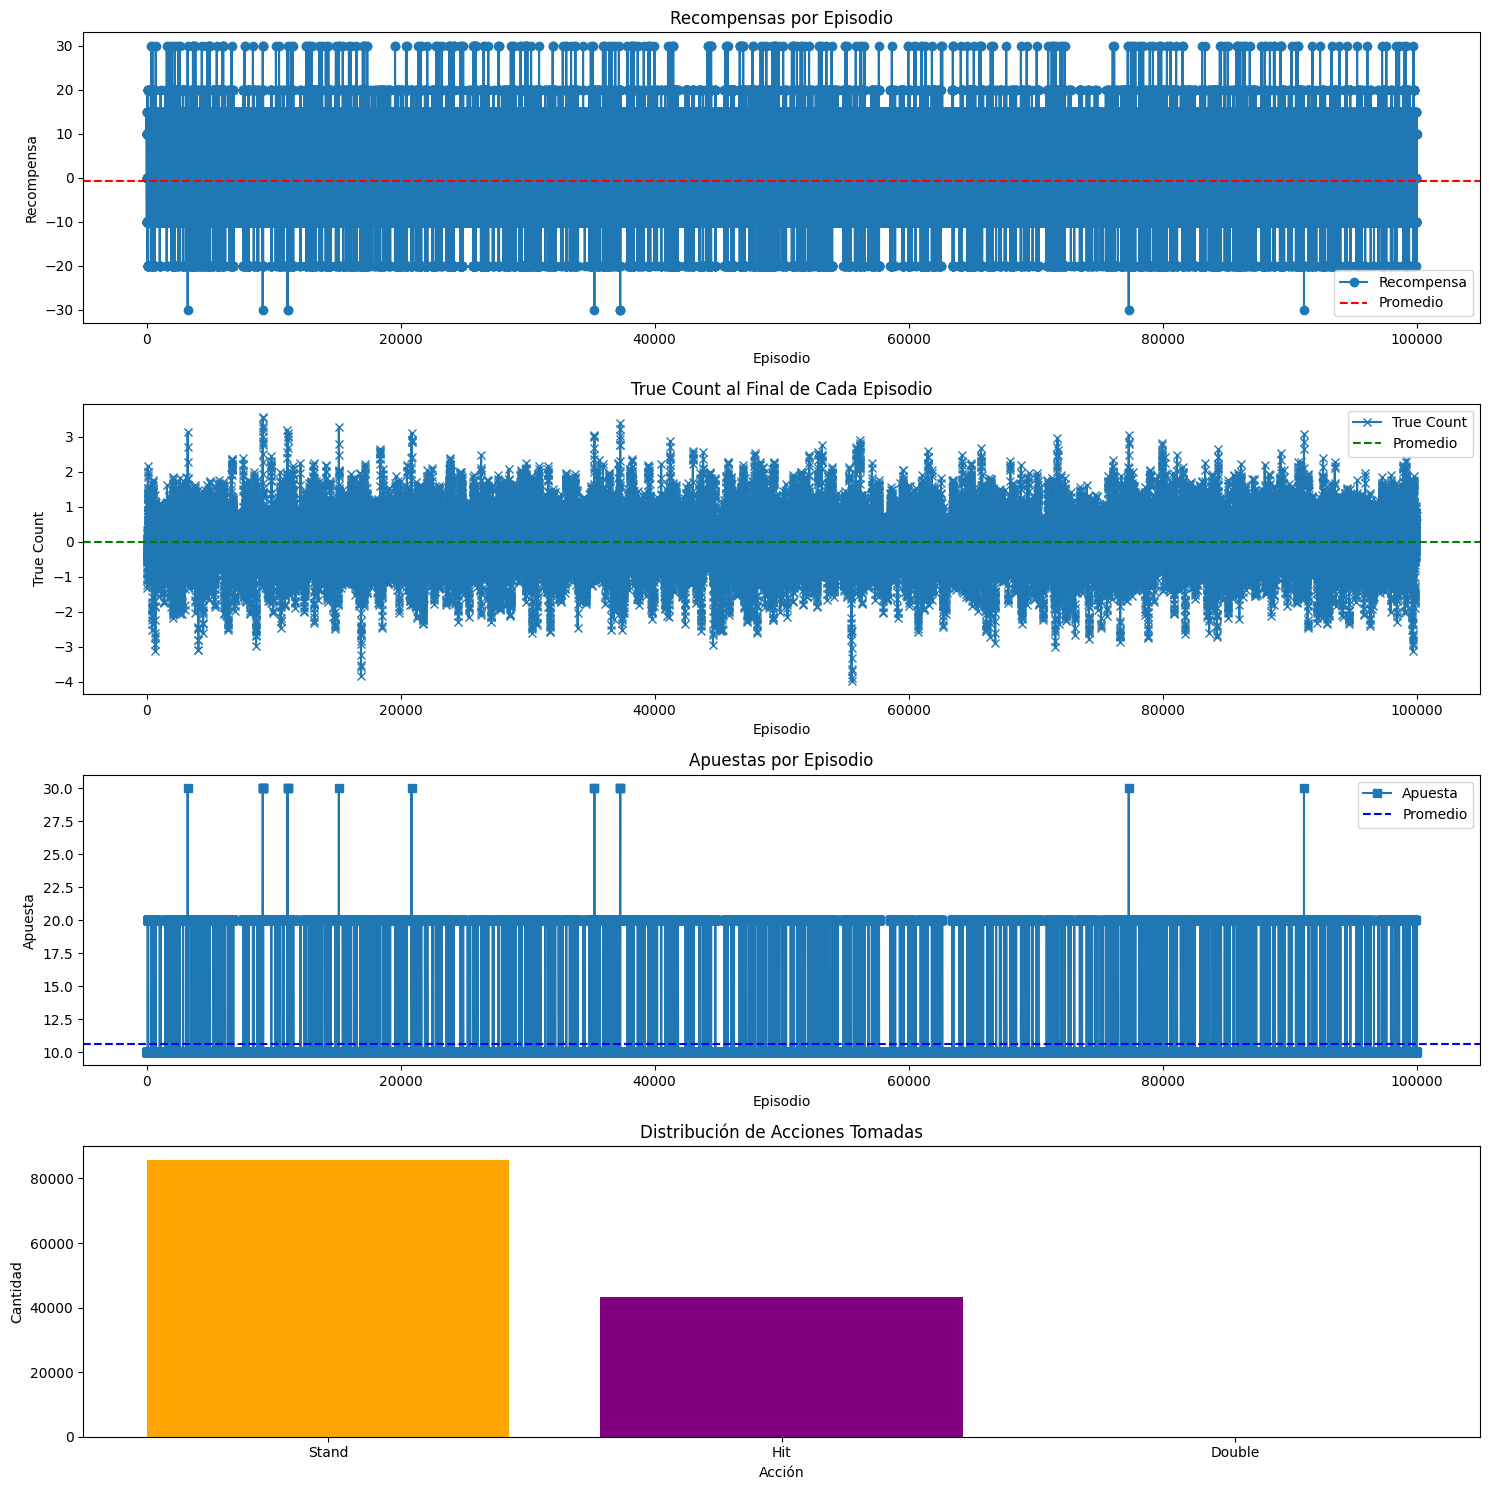

In [21]:
from stable_baselines3 import A2C
from collections import Counter
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
model = A2C.load("a2c_blackjack.zip")

# Evaluar el modelo y registrar métricas
num_episodes = 100000
rewards = []       # Lista para recompensas por episodio
true_counts = []   # Lista para True Count al final de cada episodio
bets = []          # Lista para apuestas por episodio
actions_count = Counter({"Stand": 0, "Hit": 0, "Double": 0})  # Contador de acciones
bust_count = 0     # Contador de veces que el jugador se pasa de 21

obs, _ = env.reset()
for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Registrar la acción tomada
        if action == 0:
            actions_count["Stand"] += 1
        elif action == 1:
            actions_count["Hit"] += 1
        elif action == 2:
            actions_count["Double"] += 1

        # Verificar si el jugador se pasa de 21 usando el estado (obs)
        player_sum = obs[0]  # Asegúrate de que obs[0] representa la suma de la mano del jugador
        if player_sum > 21:
            bust_count += 1

    # Registrar métricas al final del episodio
    rewards.append(total_reward)
    true_counts.append(env.true_count)
    bets.append(env.current_bet)

    # Imprimir log del episodio
    print(f"\n--- Episodio {episode + 1} ---")
    print(f"Recompensa total en el episodio {episode + 1}: {total_reward}")
    for log_entry in env.log:
        print(log_entry)
    env.log = []  # Limpiar el registro para la próxima ronda

# Calcular victorias, derrotas y empates
wins = len([r for r in rewards if r > 0])
losses = len([r for r in rewards if r < 0])
draws = len([r for r in rewards if r == 0])

# Análisis de las métricas
print("\n--- Resumen de resultados ---")
print(f"Episodios totales: {num_episodes}")
print(f"Victorias: {wins} ({(wins / num_episodes) * 100:.2f}%)")
print(f"Derrotas: {losses} ({(losses / num_episodes) * 100:.2f}%)")
print(f"Empates: {draws} ({(draws / num_episodes) * 100:.2f}%)")
print(f"Recompensa total: {sum(rewards):.2f}")
print(f"Recompensa promedio por episodio: {np.mean(rewards):.2f}")
print("\nAcciones tomadas:")
print(f"Stand: {actions_count['Stand']}")
print(f"Hit: {actions_count['Hit']}")
print(f"Double: {actions_count['Double']}")
print(f"Veces que el jugador se pasa de 21: {bust_count}")

# Generar gráficos de métricas
plt.figure(figsize=(15, 15))

# Gráfico 1: Recompensas por episodio
plt.subplot(4, 1, 1)
plt.plot(range(1, num_episodes + 1), rewards, marker='o', linestyle='-', label="Recompensa")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label="Promedio")
plt.title("Recompensas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()

# Gráfico 2: True Count por episodio
plt.subplot(4, 1, 2)
plt.plot(range(1, num_episodes + 1), true_counts, marker='x', linestyle='-', label="True Count")
plt.axhline(y=np.mean(true_counts), color='g', linestyle='--', label="Promedio")
plt.title("True Count al Final de Cada Episodio")
plt.xlabel("Episodio")
plt.ylabel("True Count")
plt.legend()

# Gráfico 3: Apuestas por episodio
plt.subplot(4, 1, 3)
plt.plot(range(1, num_episodes + 1), bets, marker='s', linestyle='-', label="Apuesta")
plt.axhline(y=np.mean(bets), color='b', linestyle='--', label="Promedio")
plt.title("Apuestas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Apuesta")
plt.legend()

# Gráfico 4: Distribución de acciones
plt.subplot(4, 1, 4)
actions_labels = ["Stand", "Hit", "Double"]
actions_values = [actions_count["Stand"], actions_count["Hit"], actions_count["Double"]]
plt.bar(actions_labels, actions_values, color=['orange', 'purple', 'cyan'])
plt.title("Distribución de Acciones Tomadas")
plt.xlabel("Acción")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()